In [1]:
import warnings
warnings.filterwarnings("ignore")

# Domain libraries

Different domain libraries contain foundational models ready for `transfer learning`.

| Problem Space         | Pre-trained models |
| :-------------------: | :------------------------------: |
| Vision                | `torchvision.models`             |
| Text                  | `torchtext.models`               |
| Audio                 | `torchaudio.models`              |
| Recommendation system | `torchrec.models`                |

Depending on what you are working on, other sources of pre-trained models include [HuggingFace Models](https://huggingface.co/models) and [Hugging Face TIMM](https://github.com/huggingface/pytorch-image-models), [Pytorch Image Models](https://timm.fast.ai/) and [Paper with code SOTA](https://paperswithcode.com/sota). For working with Pytorch Image Models, useful guidance is provided by this [article](https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055).

In [2]:
import torch
import torchvision

torch.__version__, torchvision.__version__

('2.1.1', '0.16.1')

# Setup device agnostic code

**Note**: Sometimes, depending on your data/hardware, you might find that your model trains faster on CPU than GPU. It could be that the overhead for copying data/model to and from the GPU outweighs the compute benefits offered by the GPU.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Transfer learning

Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task. In the context of deep learning, transfer learning is typically done by removing the last layer(s) of a pre-trained model and replacing them with a new layer(s) that is specific to the new task. In this exercise, we will use the EfficientNet model pre-trained on ImageNet based on the [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946) paper.

# 1. Transform data and load into `DataLoaders`

When working with foundational models, attention needs to be paid to how the data will be **transformed** and **loaded** into the model. It is important that the data (including custom) is transformed in the same way as the data used to train the foundational model.

1. Manually created transforms: transforms are defined by the modeler (not recommended)
2. Automatically created transforms: transforms are defined by the foundational model architecture

## 1.1. Original data visualization

In [4]:
import pathlib
from torchvision.datasets import ImageFolder

target_dir = pathlib.Path("data/food-101/pizza-steak-sushi")
original_data = ImageFolder(root=target_dir / "train")

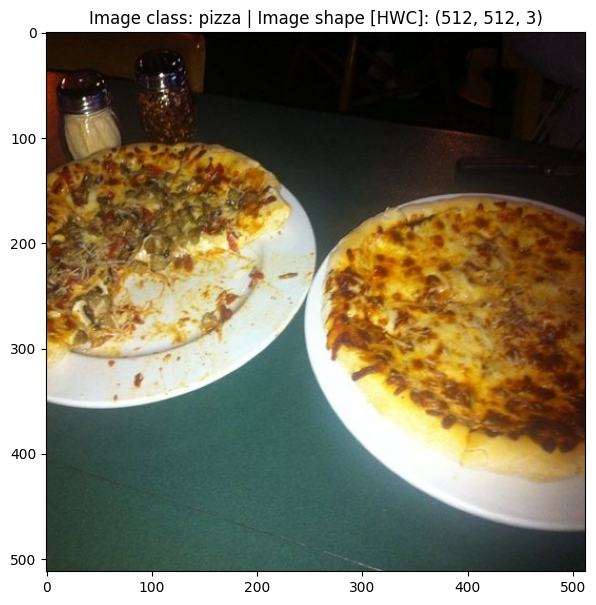

In [5]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.array(original_data[0][0])

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {original_data.classes[original_data[0][1]]} | Image shape [HWC]: {img_as_array.shape}");

## 1.1. Manually created transforms

**From the documentation PyTorch Vision version 0.12**:

> "All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]"

Normalization is performed to make sure that images have the same distribution as the images used to train the model. This is important because the model was trained on images with a specific distribution and if the distribution of the images used to train the model is different from the distribution of the images used to make predictions, the model will not perform well.

In [6]:
from torchvision.transforms import v2

normalize = v2.Normalize(
    mean=[0.485, 0.456, 0.406], 
    std=[0.229, 0.224, 0.225]
)

manual_transforms = v2.Compose([
    v2.Resize(224),
    v2.ToTensor(),
    normalize
])

In [7]:
train_data_manual = ImageFolder(root=target_dir / "train", transform=manual_transforms)
test_data_manual = ImageFolder(root=target_dir / "test", transform=manual_transforms)
train_data_manual, test_data_manual

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/food-101/pizza-steak-sushi/train
     StandardTransform
 Transform: Compose(
                  Resize(size=[224], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                  ToTensor()
                  Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/food-101/pizza-steak-sushi/test
     StandardTransform
 Transform: Compose(
                  Resize(size=[224], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                  ToTensor()
                  Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
            ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


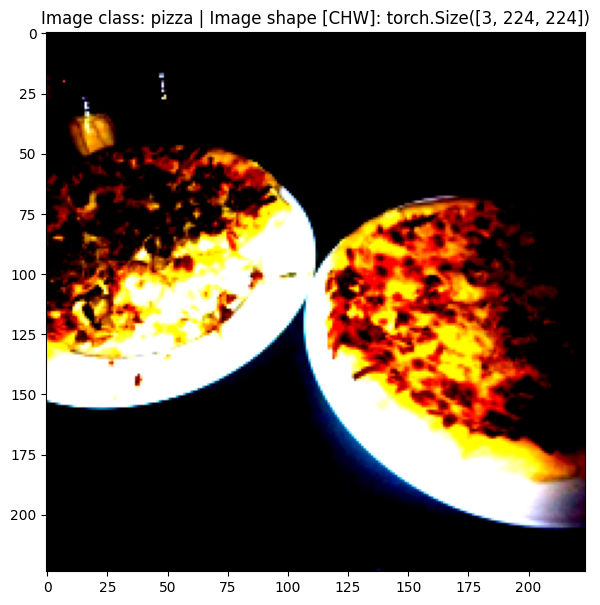

In [8]:
img_as_array = np.array(train_data_manual[0][0]).transpose(1, 2, 0)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {train_data_manual.classes[train_data_manual[0][1]]} | Image shape [CHW]: {train_data_manual[0][0].shape}");

## 1.2. Automatically created transforms

As of `torchvision` v0.13+, models come with a `transforms` method on the weights object that automatically creates the transforms required to make predictions with the model. The input of the transforms can be either a `PIL.Image` or a `Tensor` read using `torchvision.io`. This is the recommended way to create transforms for foundational models.

Some models use modules which have different **training and evaluation behavior**, such as batch normalization. To switch between these modes, use `model.train()` or `model.eval()` as appropriate.

```py
# Initialize model
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)

# Set model to eval mode
model.eval()
```

In [9]:
# get a set of pre-trained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [10]:
# Iterating the items of the meta-data dictionary
for k, v in weights.meta.items():
    print(k, v)

categories ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'rock python', 'Indian cobra', 'green mamba', 'sea snake', 'horned viper', 'dia

In [11]:
# get transforms used to create pre-trained model
auto_transforms = weights.transforms()
auto_transforms

train_data_auto = ImageFolder(root=target_dir / "train", transform=auto_transforms)
test_data_auto = ImageFolder(root=target_dir / "test", transform=auto_transforms)
train_data_auto, test_data_auto

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/food-101/pizza-steak-sushi/train
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/food-101/pizza-steak-sushi/test
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


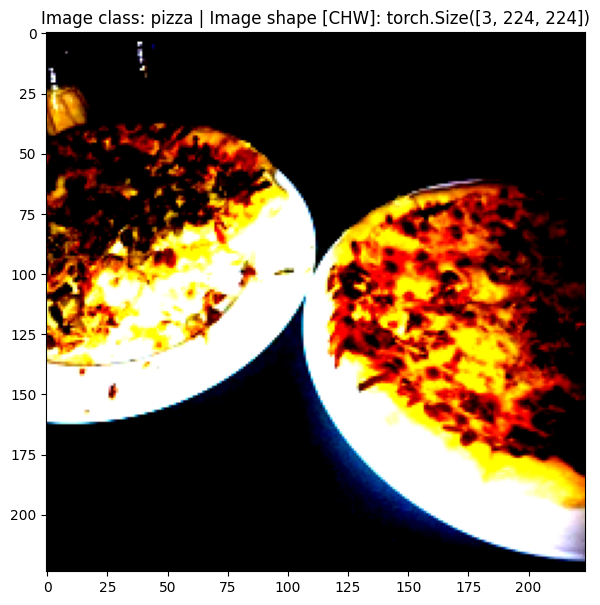

In [12]:
img_as_array = np.array(train_data_auto[0][0]).transpose(1, 2, 0)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {train_data_auto.classes[train_data_auto[0][1]]} | Image shape [CHW]: {train_data_auto[0][0].shape}");

In [13]:
import os
from torch.utils.data import DataLoader

# setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# create data loaders
train_dataloader_auto = DataLoader(dataset=train_data_auto,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader_auto = DataLoader(dataset=test_data_auto,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

len(train_dataloader_auto), len(test_dataloader_auto)

(8, 3)

# 2. Load a pre-trained model

The whole idea of transfer learning is to use a model that has been trained on a large dataset and then re-purpose it for a new task. In general, when picking a pre-trained model, there are three things to consider:

1. Speed: how fast does the model make predictions?
2. Size: how large is the model?
3. Performance: how well does the model perform on a given task?

In most cases, these criteria will involve a trade-off between accuracy and speed/size. For example, a model that is more accurate will typically be slower and larger than a model that is less accurate.

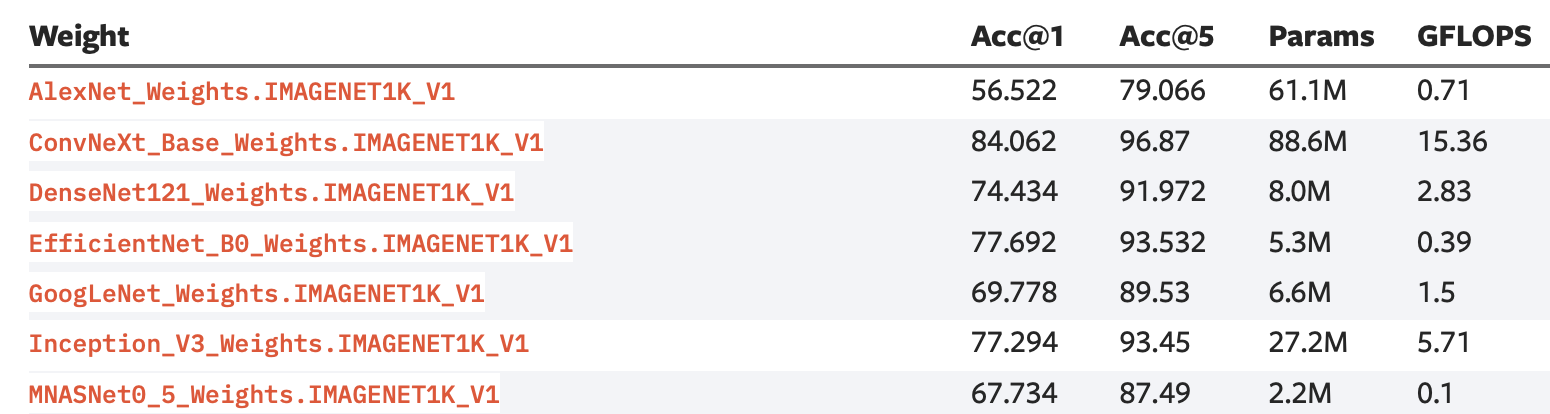

The backbone of SOTA models are unfathomably large. For example, the [GPT-3](https://arxiv.org/abs/2005.14165) model has 175 billion parameters. To address this issue, most often than not, instead of building proprietary models, it is better to use pre-trained models that have been trained on large datasets. This is because pre-trained models are typically trained on large datasets and have been shown to perform well on a variety of tasks. For example, the [EfficientNet](https://arxiv.org/abs/1905.11946) model is a family of models that are smaller and faster than the [ResNet](https://arxiv.org/abs/1512.03385) model while achieving similar accuracy.

In [14]:
from torchvision.models import efficientnet_b0

model = efficientnet_b0(weights=weights).to(device)

## 2.1. Feature extraction

Feature extraction is a type of transfer learning in which the weights of a pre-trained model are used to extract features from a new dataset. Most of the layers of the original model remain frozen during training and only the classification features extracted from the new dataset are used to train a new classifier. This is useful when there is a small amount of data available for training.

The **feature extractor** is the part of the model that is responsible for creating the feature vectors. The feature extractor is typically the convolutional layers of the model, which constitute its backbone. The feature extractor is frozen during training and only the classifier is trained.

After feature extraction, an **average pooling layer** is applied to the feature vectors to create a single feature vector per image. The average pooling layer is typically a global average pooling layer.

Finally, the model's **classifier** turns feature vectors into prediction logits. The classifier is typically a fully connected layer that can be adjusted on the number of classes in the new dataset.

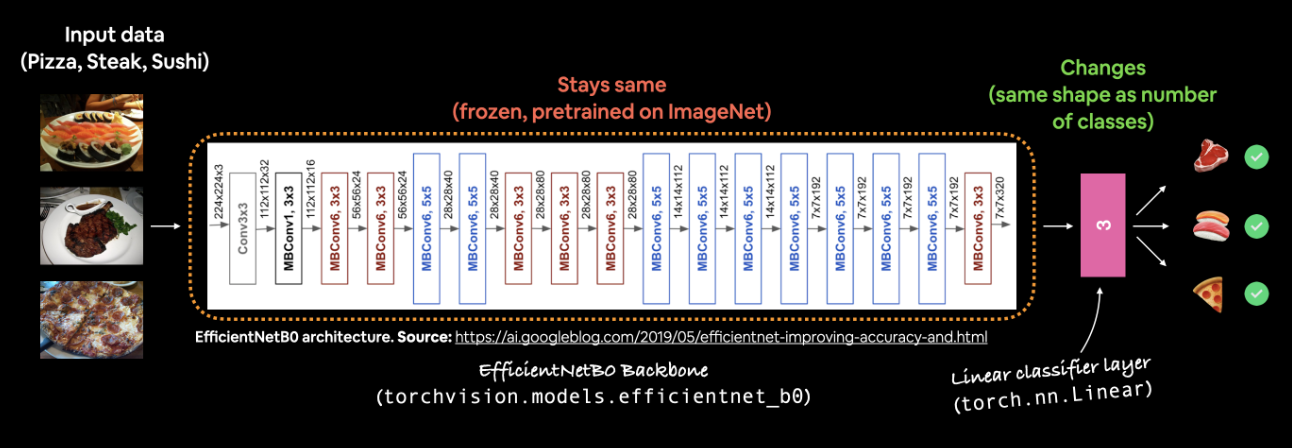

In practice, what happens is that only the classifier layer is retrained on the new dataset, while the feature extractor is frozen. This is because the feature extractor has already learned to extract features from images and the classifier layer is the only part of the model that needs to be retrained on the new dataset.

Other type of transfer learning is **fine-tuning**, in which the feature extractor is also retrained on the new dataset. This is typically done when the new dataset is similar to the dataset used to train the model. For example, if the model was trained on ImageNet and the new dataset is a large enough subset of ImageNet, then fine-tuning the feature extractor is recommended.

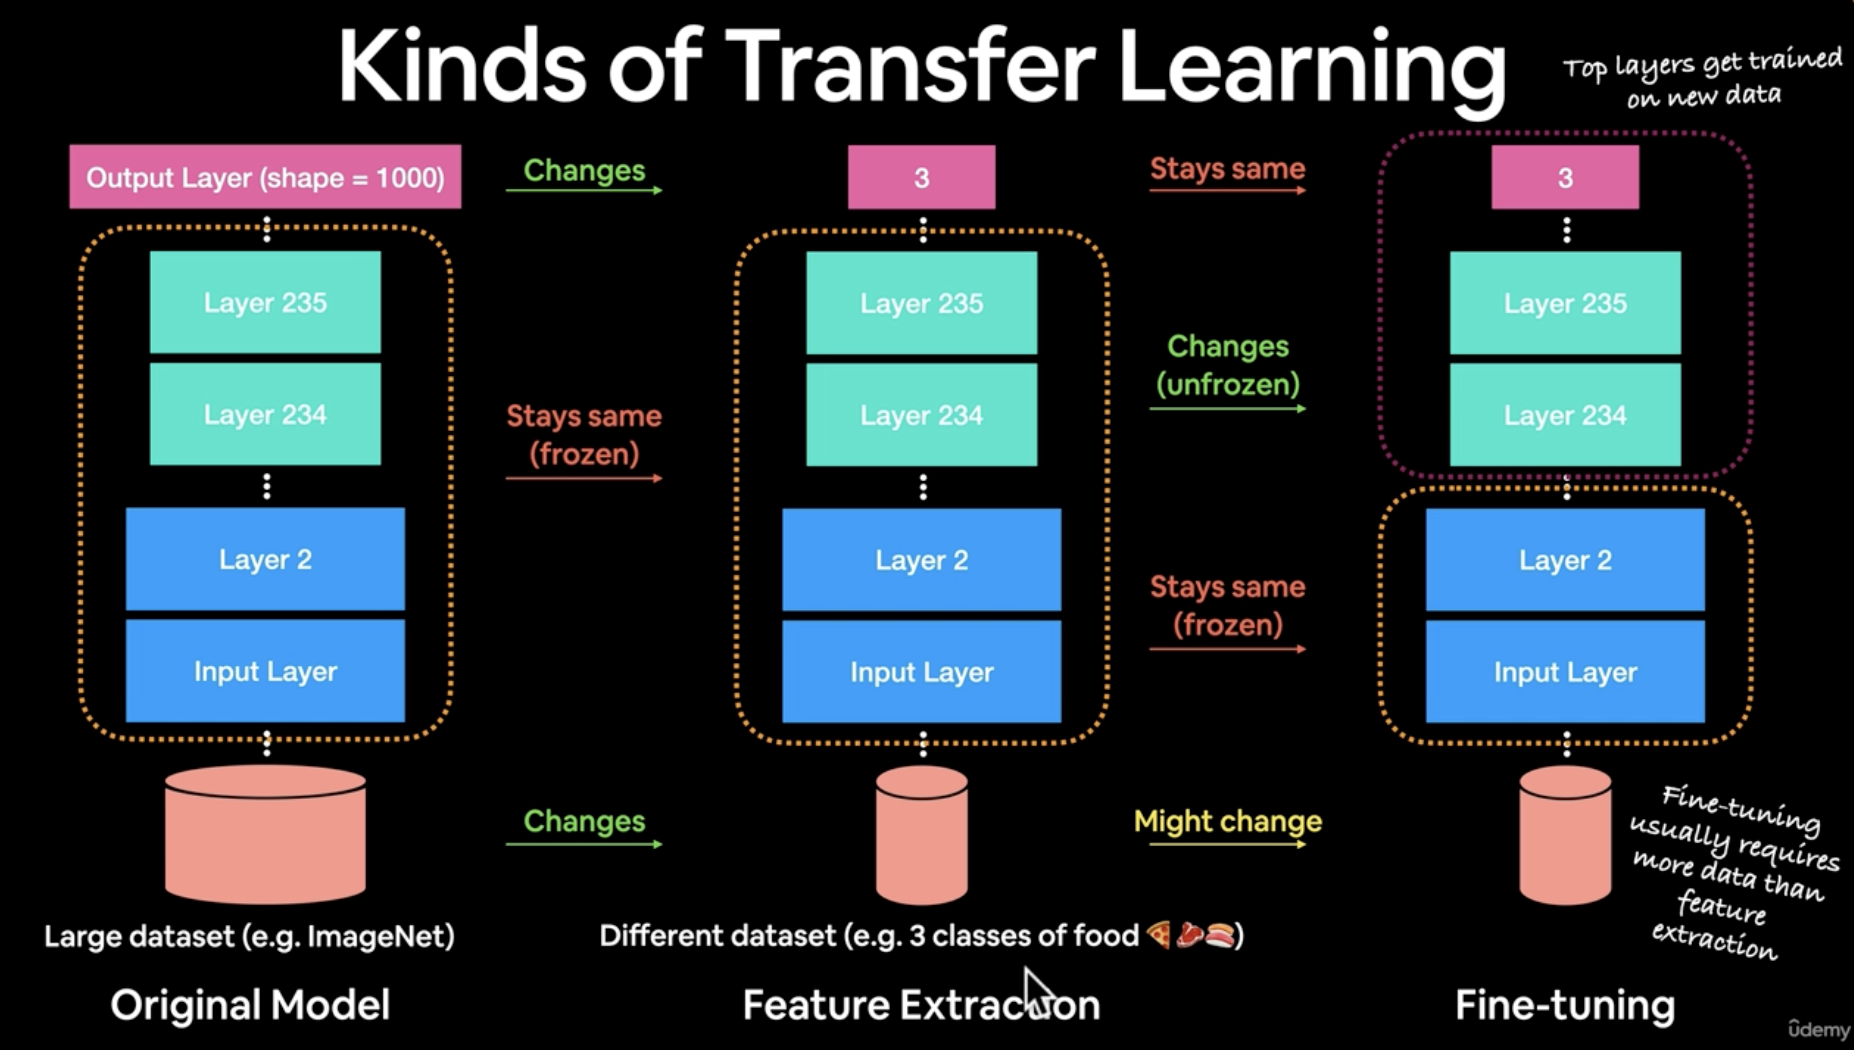

In [15]:
from torchinfo import summary

summary(
  model, 
  input_size=(BATCH_SIZE, 3, 224, 224), 
  col_names=["input_size", "output_size", "num_params", "trainable"],
  row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --                

## 2.2. Freeze feature extractor and update classifier head

In [16]:
# freeze all base layers in backbone
for param in model.features.parameters():
    param.requires_grad = False

In [17]:
# update the classifier head
from torch import nn

torch.manual_seed(42), torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(train_data_auto.classes))
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [18]:
summary(
  model, 
  input_size=(BATCH_SIZE, 3, 224, 224), 
  col_names=["input_size", "output_size", "num_params", "trainable"],
  row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

## 2.3. Train model

In [19]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
import torchmetrics

def train_model(
        model: torch.nn.Module, 
        loss_fn: torch.nn.Module, 
        optim: torch.optim.Optimizer, 
        accuracy: torchmetrics.Metric, 
        f1: torchmetrics.Metric, 
        train_dataloader: DataLoader, 
        test_dataloader: DataLoader, 
        epochs: int = 5,
        model_name: str = "baseline-model"):
    """Performs training and evaluation of the model"""

    total_train_time = 0

    for epoch in tqdm(range(epochs)):
        start = timer()

        # training
        train_loss_per_batch = train_acc_per_batch = train_f1_per_batch = 0

        model.train()
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)

            # forward pass
            logits = model(X)
            loss = loss_fn(logits, y)
            train_loss_per_batch += loss.item()

            # backward pass
            optim.zero_grad()
            loss.backward()

            # update parameters
            optim.step()

            # calculate accuracy and f1 score
            train_acc_per_batch += accuracy(logits.softmax(dim=1), y).item()
            train_f1_per_batch += f1(logits.softmax(dim=1), y).item()

        train_loss_per_batch /= len(train_dataloader)
        train_acc_per_batch /= len(train_dataloader)
        train_f1_per_batch /= len(train_dataloader)

        # testing
        test_loss_per_batch = test_acc_per_batch = test_f1_per_batch = 0

        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)

                # forward pass
                logits = model(X)
                loss = loss_fn(logits, y)
                test_loss_per_batch += loss.item()

                # calculate accuracy and f1 score
                test_acc_per_batch += accuracy(logits.softmax(dim=1), y).item()
                test_f1_per_batch += f1(logits.softmax(dim=1), y).item()

        test_loss_per_batch /= len(test_dataloader)
        test_acc_per_batch /= len(test_dataloader)
        test_f1_per_batch /= len(test_dataloader)

        end = timer()
        total_train_time += end - start
        print(f"Epoch: {epoch + 1}/{epochs}, "
                f"train_loss: {train_loss_per_batch:.4f}, test_loss: {test_loss_per_batch:.4f}, "
                f"train_acc: {train_acc_per_batch:.4f}, test_acc: {test_acc_per_batch:.4f}, "
                f"train_f1: {train_f1_per_batch:.4f}, test_f1: {test_f1_per_batch:.4f}, "
                f"time: {end - start:.2f}s")
        
    return {
        "train_loss": train_loss_per_batch,
        "train_acc": train_acc_per_batch,
        "train_f1": train_f1_per_batch,
        "test_loss": test_loss_per_batch,
        "test_acc": test_acc_per_batch,
        "test_f1": test_f1_per_batch,
        "total_train_time": total_train_time,
        "model_name": model_name
    }

In [21]:
from torchmetrics import Accuracy, F1Score

# set seed for reproducibility
torch.manual_seed(42), torch.cuda.manual_seed(42)

# pick loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model.parameters(), lr=0.001)

# define eval metrics
accuracy = Accuracy(task="multiclass", num_classes=len(train_data_auto.classes)).to(device)
f1 = F1Score(task="multiclass", num_classes=len(train_data_auto.classes)).to(device)

# train model
model_metrics = train_model(model, loss_fn, optim, accuracy, f1, train_dataloader_auto, test_dataloader_auto, model_name="custom-efficientnet-b0")

 20%|██        | 1/5 [01:25<05:40, 85.12s/it]

Epoch: 1/5, train_loss: 1.0883, test_loss: 0.8914, train_acc: 0.4180, test_acc: 0.6818, train_f1: 0.4180, test_f1: 0.6818, time: 85.11s


 40%|████      | 2/5 [02:50<04:15, 85.15s/it]

Epoch: 2/5, train_loss: 0.9162, test_loss: 0.8027, train_acc: 0.6289, test_acc: 0.7443, train_f1: 0.6289, test_f1: 0.7443, time: 85.17s


 60%|██████    | 3/5 [04:15<02:50, 85.17s/it]

Epoch: 3/5, train_loss: 0.8162, test_loss: 0.6787, train_acc: 0.7031, test_acc: 0.9072, train_f1: 0.7031, test_f1: 0.9072, time: 85.19s


 80%|████████  | 4/5 [05:41<01:25, 85.31s/it]

Epoch: 4/5, train_loss: 0.7460, test_loss: 0.6744, train_acc: 0.7305, test_acc: 0.8040, train_f1: 0.7305, test_f1: 0.8040, time: 85.52s


100%|██████████| 5/5 [07:04<00:00, 84.94s/it]

Epoch: 5/5, train_loss: 0.6209, test_loss: 0.6263, train_acc: 0.7695, test_acc: 0.8561, train_f1: 0.7695, test_f1: 0.8561, time: 83.66s


In [22]:
model_metrics

{'train_loss': 0.620859906077385,
 'train_acc': 0.76953125,
 'train_f1': 0.76953125,
 'test_loss': 0.6262964407602946,
 'test_acc': 0.8560606042544047,
 'test_f1': 0.8560606042544047,
 'total_train_time': 424.657471209,
 'model_name': 'custom-efficientnet-b0'}

# References

1. [PyTorch Official Documentation - Transforming and Augmenting Images](https://pytorch.org/vision/stable/transforms.html)
2. [PyTorch Official Documentation - Models and Pre-Trained Weights](https://pytorch.org/vision/stable/models.html)
3. [Introducing TorchVision’s New Multi-Weight Support API](https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/)
4. [Medium - Getting Started with PyTorch Image Models (timm): A Practitioner’s Guide](https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055)
5. [The Bitter Lesson, by Rich Sutton](http://www.incompleteideas.net/IncIdeas/BitterLesson.html)
6. [Ground Truth Notebook](https://www.learnpytorch.io/06_pytorch_transfer_learning/)